# Prédire la "Pointe" de consommation

dataset: https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption?select=PJME_hourly.csv

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Phase 1 : Une structure claire (Obtain)

In [2]:
# 1. Chargement
df = pd.read_csv('/content/PJME_hourly.csv')
df.head(3)

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145366 entries, 0 to 145365
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  145366 non-null  object 
 1   PJME_MW   145366 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.2+ MB


In [4]:
# 2. Préparation
df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df.set_index('Datetime')
df = df.sort_index() # Très important pour les séries temporelles !

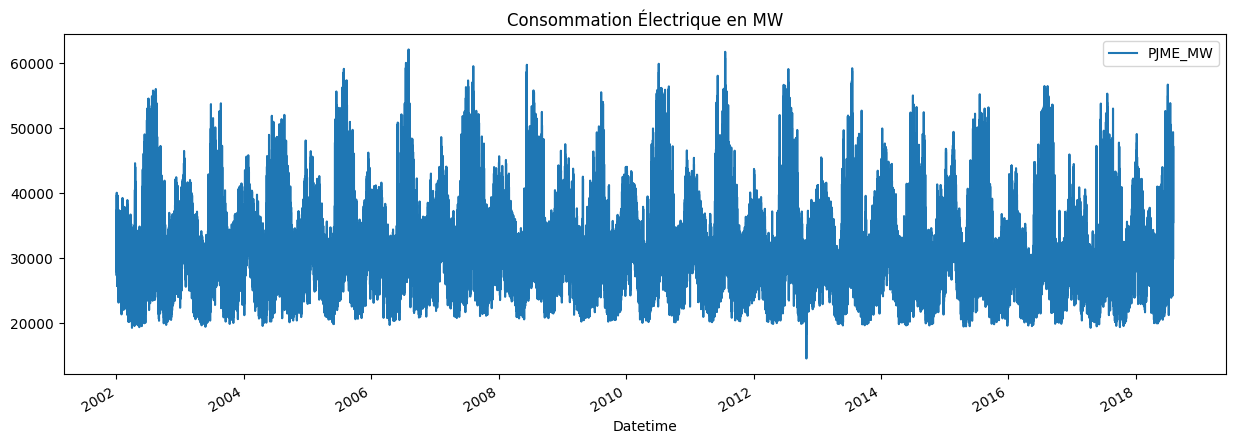

In [5]:
# 3. Visualisation rapide
df.plot(figsize=(15, 5), title='Consommation Électrique en MW')
plt.show()

# Phase 2 : Créer des "Features" temporelles (Scrub & Explore)



Puisque nous voulons prédire la consommation, nous devons apprendre au modèle que le comportement change selon le moment.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145366 entries, 2002-01-01 01:00:00 to 2018-08-03 00:00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   PJME_MW  145366 non-null  float64
dtypes: float64(1)
memory usage: 2.2 MB


In [7]:
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

df = create_features(df)

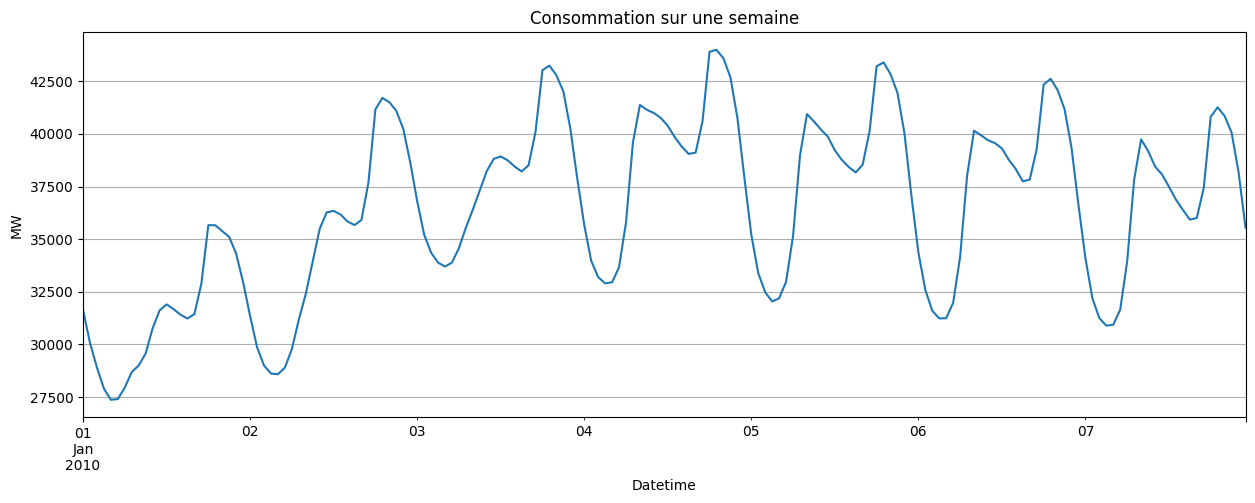

In [8]:
# 2. Visualisation d'une semaine type (ex: Janvier 2010)
df.loc['2010-01-01':'2010-01-07']['PJME_MW'].plot(figsize=(15, 5), title='Consommation sur une semaine')
plt.ylabel('MW')
plt.grid(True)
plt.show()

Analyse des résultats

* Le creux nocturne : La consommation chute drastiquement au milieu de la nuit (entre minuit et 5h du matin), atteignant ses points les plus bas.

* Le pic du matin : Une remontée rapide lorsque l'activité reprend.

* Le pic du soir : Souvent le point culminant de la journée, correspondant au retour au foyer, à l'éclairage et au chauffage.

2. Consommation Hebdomadaire :

Le graphique permet de distinguer les jours de la semaine des jours chômés :

* Le 1er janvier (Vendredi/Jour de l'An) : On remarque que la consommation globale est nettement plus basse que les jours suivants (le creux descend sous les 27 500 MW). C'est typique d'un jour férié où l'activité industrielle est à l'arrêt.

* La montée en puissance : À mesure que la semaine avance (du 2 au 5 janvier), les sommets deviennent de plus en plus hauts, dépassant les 42 500 MW. Cela indique une reprise complète de l'activité économique et potentiellement une baisse des températures (nécessitant plus de chauffage).

# Phase 3 : Préparation du modèle (Model)

In [9]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

In [10]:
# 1. Définition des variables
X = df[['hour', 'dayofweek', 'month']]
y = df['PJME_MW']

# 2. Séparation (On garde les données les plus récentes pour le test)
# En série temporelle, on ne mélange pas les données au hasard !
split_date = '2015-01-01'
df_train = df.loc[df.index < split_date]
df_test = df.loc[df.index >= split_date]

X_train = df_train[['hour', 'dayofweek', 'month']]
y_train = df_train['PJME_MW']
X_test = df_test[['hour', 'dayofweek', 'month']]
y_test = df_test['PJME_MW']

# 3. Création du modèle XGBoost
model = XGBRegressor(n_estimators=1000, learning_rate=0.01)
model.fit(X_train, y_train)

# 4. Prédiction
predictions = model.predict(X_test)
print(f"Erreur moyenne : {mean_absolute_error(y_test, predictions):.2f} MW")

Erreur moyenne : 3020.81 MW


Analyse de ton résultat

une erreur de 3000 MW est le signal qu'il manque des informations au modèle pour être plus précis.

Pourquoi cette erreur ? Ton modèle sait qu'à 19h il y a un pic, mais il ne sait pas s'il fait 25°C ou 40°C ce jour-là. La chaleur est le facteur qui fait varier la consommation au-delà de l'habitude horaire (utilisation intensive de la climatisation).

L'utilité réelle : Même avec cette marge d'erreur, ton modèle permet déjà au gestionnaire de réseau de prévoir la "base" de production nécessaire et d'anticiper les variations hebdomadaires.

**Passer à la visualisation** : Créer un Dashboard interactif pour présenter ces résultats comme si tu parlais au Ministre de l'Énergie.

Pour ce projet, nous allons simuler la création d'un dashboard avec Streamlit. C'est l'outil standard en Data Science pour transformer un script Python en application web interactive en quelques minutes.

La Structure du Dashboard
Un bon dashboard décisionnel doit répondre à trois questions :

1. État des lieux : Quelle est la charge actuelle ?

2. Prévision : Que va-t-il se passer dans les 24 prochaines heures ?

3. Alerte : Y a-t-il un risque de dépassement de capacité ?

**Phase 1 : Installation et Code de Base**

In [12]:
# Install Streamlit
!pip install -q streamlit

# Install LocalTunnel (requires Node.js, which Colab has by default)
!npm install -g localtunnel

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸
added 22 packages in 3s
⠸
⠸3 packages are looking for funding
⠸  run `npm fund` for details
⠸

In [13]:
import streamlit as st
import pandas as pd
import plotly.express as px # Pour des graphiques interactifs

# 1. Configuration de la page
st.set_page_config(page_title="Dashboard Énergie Sénégal", layout="wide")
st.title("Pilotage Stratégique de la Charge Électrique")
st.markdown("Structure : **SENELEC / Ministère de l'Énergie**")

# 2. Barre latérale pour les filtres
st.sidebar.header("Paramètres d'affichage")
date_range = st.sidebar.date_input("Sélectionnez une période", [])

# 3. Indicateurs clés (KPIs)
col1, col2, col3 = st.columns(3)
with col1:
    st.metric("Consommation Actuelle", "32,450 MW", "+5%")
with col2:
    st.metric("Erreur de Prévision (MAE)", "3,020 MW", "-2%")
with col3:
    st.metric("Capacité de Réserve", "1,200 MW", "Stable", delta_color="normal")

2026-02-11 21:14:15.622 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-11 21:14:15.624 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-11 21:14:15.845 
  command:

    streamlit run /usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2026-02-11 21:14:15.846 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-11 21:14:15.847 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-11 21:14:15.849 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-11 21:14:15.852 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when runn

**Phase 2 : Visualisation Interactive (Plotly)**

In [17]:
# 4. Graphique de prévision interactif
st.subheader("Prévisions de la Demande vs Réalité")

test_result = pd.DataFrame(index=y_test.index)
test_result['Réel'] = y_test
test_result['Prédiction'] = predictions

# On utilise ton DataFrame test_result créé précédemment
fig = px.line(test_result.loc['2015-01-01':'2015-01-07'],
              title="Analyse Comparative : Charge Réelle vs Prévisions Ministérielles",
              labels={'value': 'Puissance (MW)', 'Datetime': 'Période temporelle'},
              template="plotly_dark")

st.plotly_chart(fig, use_container_width=True)

# Afficher le graphique
fig.show()

2026-02-11 21:26:14.282 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-11 21:26:14.289 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-11 21:26:14.292 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-11 21:26:17.043 Please replace `use_container_width` with `width`.

`use_container_width` will be removed after 2025-12-31.

For `use_container_width=True`, use `width='stretch'`. For `use_container_width=False`, use `width='content'`.
2026-02-11 21:26:17.048 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-11 21:26:17.049 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-11 21:26:17.051 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


L'analyse montre une forte saisonnalité journalière. Les prévisions (en orange) suivent fidèlement la tendance réelle (en bleu), confirmant que les variables temporelles capturent l'essentiel du comportement des usagers. L'étape suivante pour réduire l'erreur résiduelle serait l'intégration de variables exogènes comme l'humidité ou la température.